### kaggle 집값 예측 문제

columns

- `house_id` - 주택 id변수
- `date` - 판매된 날자
- `location` - 주택 위치
- `type` - 주택 유형 ("2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE")
- `block` - 주택이 위치한 블록
- `street` - 주택이 위치한 거리
- `storey_range` - 주택이 위치한 층 범위
- `area_sqm	` - 주택의 면적
- `flat_model` - 주택의 모델(구조, 방 배치 등)
- `commence_date` - 주택이 판매에 올라온 날짜
- `price` - 판매 가격 (목표 변수)

additional columns

- `type_num` - 방의 개수
- `area_per_room` - 방 하나당 평균 면적
- `price_per_unitarea` - 단위면적(1m^2)당 가격
- `adress` - 주소
- `Year` - 판매 연도
- `Month` - 판매 월
- `time_to_sell` - 판매까지 걸린 연도

추가사항

- `price_per_room` - 방하나당 평균 가격
- `interest_rate` - 집이 팔린 당시의 금리

다양한 변수를 사용하여 짒값을 예측한다
-> baseline code작성

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  cross_val_score

import seaborn as sns

In [46]:
# 데이터 불러오기
try:
    data = pd.read_csv('data/test.csv',encoding='utf-8')
    train = pd.read_csv('data/train.csv',encoding='utf-8')
except UnicodeDecodeError:
    # UTF-8로 실패할 경우 CP949로 재시도
    data = pd.read_csv('data/test.csv',encoding='cp949-8')
    train = pd.read_csv('data/train.csv',encoding='cp949')

In [47]:
data.tail()

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date
67925,339632,2012-02,Riverside,4 ROOM,610,Northpark Dr,04 TO 06,84.0,N,1986
67926,339639,2012-02,Riverside,5 ROOM,796,Laredo Rd,04 TO 06,123.0,D,1987
67927,339642,2012-02,Riverside,5 ROOM,855,Laredo Rd,04 TO 06,127.0,D,1988
67928,339643,2012-02,Riverside,5 ROOM,366,Laredo Rd,07 TO 09,122.0,D,1988
67929,339644,2012-02,Riverside,5 ROOM,115B,Laredo Rd,16 TO 18,111.0,D,2001


In [48]:
train.tail()

,house_id,date,location,type,block,street,storey_range,area_sqm,flat_model,commence_date,price
271716,101563,2003-01,Omaha,4 ROOM,483,Sandra Ln,04 TO 06,103.0,G,1989,232000.0
271717,28297,2000-11,Omaha,5 ROOM,615,Atkin Rd,10 TO 12,134.0,G,1996,428000.0
271718,321995,2011-04,Boston,5 ROOM,390,Kempton Street,13 TO 15,118.0,D,2004,548888.0
271719,308162,2010-09,Fresno,4 ROOM,968,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0
271720,225691,2007-10,Milwaukee,EXECUTIVE,341,W Fond du Lac Avenue,04 TO 06,143.0,C,1993,450000.0


### EDA

In [49]:
#기초 통계량 확인
train.describe()

,house_id,area_sqm,commence_date,price
count,271721.000000,271721.000000,271721.000000,271721.000000
mean,169785.994870,96.544832,1987.982942,281197.589537
std,98022.533902,25.587877,9.125141,112160.993184
min,1.000000,28.000000,1966.000000,28000.000000
25%,85021.000000,73.000000,1981.000000,195000.000000
50%,169739.000000,99.000000,1987.000000,263000.000000
75%,254609.000000,115.000000,1997.000000,350000.000000
max,339651.000000,280.000000,2010.000000,903000.000000


In [50]:
#결측치 확인, 결측치 없음
train.isna().sum()

house_id         0
date             0
location         0
type             0
block            0
street           0
storey_range     0
area_sqm         0
flat_model       0
commence_date    0
price            0
dtype: int64

In [51]:
train['type'].value_counts()

4 ROOM              104589
3 ROOM               84422
5 ROOM               59817
EXECUTIVE            19903
2 ROOM                2602
1 ROOM                 265
MULTI-GENERATION       123
Name: type, dtype: int64

In [52]:
train['type']

0            5 ROOM
1            3 ROOM
2            4 ROOM
3            4 ROOM
4            4 ROOM
            ...    
271716       4 ROOM
271717       5 ROOM
271718       5 ROOM
271719       4 ROOM
271720    EXECUTIVE
Name: type, Length: 271721, dtype: object

In [53]:
# 방의 타입에 따른 방개수 생성
# EXECUTIVE, MULTI-GENERATION는 결측치로 변경
tmp = []
for i in train['type']:
    if i == '5 ROOM':
        tmp.append(5)
    elif i == '4 ROOM':
        tmp.append(4)
    elif i == '3 ROOM':
        tmp.append(3)
    elif i == '2 ROOM':
        tmp.append(2)
    elif i == '1 ROOM':
        tmp.append(1)
    elif i == 'EXECUTIVE':
        tmp.append(None)
    else :
        tmp.append(None)
    
train['type_num'] = tmp


In [54]:
# 결측치 확인
train['type_num'].isna().sum()

20026

In [55]:
# 방개수 결측치 중앙값으로
tmp = []

tmp = train['type_num'].fillna(train['type_num'].median())
train['type_num'] = tmp
train['type_num']

0         5.0
1         3.0
2         4.0
3         4.0
4         4.0
         ... 
271716    4.0
271717    5.0
271718    5.0
271719    4.0
271720    4.0
Name: type_num, Length: 271721, dtype: float64

In [56]:
# 방개수에 따른 방하나 평균 면적(m^2)
tmp = []
for num_rooms, area_sqm in zip(train['type_num'], train['area_sqm']):
    tmp.append(round(area_sqm/num_rooms, 3))
train['area_per_room'] = tmp

In [57]:
# 단위면적(1m^2)당 가격
tmp = []
for price, area in zip(train['price'], train['area_sqm']):
    tmp.append( round(price/area, 3) )
train['price_per_unitarea'] = tmp

In [58]:
# 지역과 블록을 합쳐 주소와 상세주소만 남긴다.
train['adress'] = train['location'] + '/' + train['block']
train.drop('location', axis=1, inplace=True)
train.drop('block', axis=1, inplace=True)
train

,house_id,date,type,street,storey_range,area_sqm,flat_model,commence_date,price,type_num,area_per_room,price_per_unitarea,adress
0,199577,2006-09,5 ROOM,Agawan Court,07 TO 09,110.0,D,2003,313000.0,5.0,22.000,2845.455,Raleigh/107D
1,217021,2007-06,3 ROOM,Cleo St,07 TO 09,64.0,N,1988,167000.0,3.0,21.333,2609.375,Fresno/678
2,308062,2010-09,4 ROOM,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,4.0,23.000,4673.913,Tucson/5
3,212465,2007-04,4 ROOM,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,4.0,23.000,3302.174,Austin/326
4,60654,2001-10,4 ROOM,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,4.0,25.500,2078.431,Honolulu/794
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,2003-01,4 ROOM,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,4.0,25.750,2252.427,Omaha/483
271717,28297,2000-11,5 ROOM,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,5.0,26.800,3194.030,Omaha/615
271718,321995,2011-04,5 ROOM,Kempton Street,13 TO 15,118.0,D,2004,548888.0,5.0,23.600,4651.593,Boston/390
271719,308162,2010-09,4 ROOM,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,4.0,22.500,4000.000,Fresno/968


In [59]:
# pivot_1.loc[('Albuquerque', '101'),:]

In [60]:
train

,house_id,date,type,street,storey_range,area_sqm,flat_model,commence_date,price,type_num,area_per_room,price_per_unitarea,adress
0,199577,2006-09,5 ROOM,Agawan Court,07 TO 09,110.0,D,2003,313000.0,5.0,22.000,2845.455,Raleigh/107D
1,217021,2007-06,3 ROOM,Cleo St,07 TO 09,64.0,N,1988,167000.0,3.0,21.333,2609.375,Fresno/678
2,308062,2010-09,4 ROOM,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,4.0,23.000,4673.913,Tucson/5
3,212465,2007-04,4 ROOM,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,4.0,23.000,3302.174,Austin/326
4,60654,2001-10,4 ROOM,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,4.0,25.500,2078.431,Honolulu/794
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,2003-01,4 ROOM,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,4.0,25.750,2252.427,Omaha/483
271717,28297,2000-11,5 ROOM,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,5.0,26.800,3194.030,Omaha/615
271718,321995,2011-04,5 ROOM,Kempton Street,13 TO 15,118.0,D,2004,548888.0,5.0,23.600,4651.593,Boston/390
271719,308162,2010-09,4 ROOM,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,4.0,22.500,4000.000,Fresno/968


In [61]:
#지역별 거래량 시각화
# plt.figure(figsize=(16,6))
# plt.title('Trading volume by location', fontsize=20, loc = 'left')
# sns.histplot(data=train, x='location',hue='Year', multiple='dodge', palette='viridis')
# plt.xticks(rotation=45)
# plt.xlabel('location')
# plt.ylabel('Trading volume')

# plt.show()

In [62]:
# 'date' 컬럼을 datetime 타입으로 변환하고, 연, 월 로 분리
tmp = {}
tmp['date'] = pd.to_datetime(train['date'])
train['Year'] = tmp['date'].dt.year
train['Month'] = tmp['date'].dt.month


In [63]:
train.drop('date', axis=1, inplace=True)

In [64]:
#팔리기까지의 기간
tmp_list = []

for i, j in zip(train['commence_date'], train['Year']):
    tmp_list.append(j-i)

train['time_to_sell'] = tmp_list

In [65]:
# train['address'] = train['location'] + '/' + train['street'] + '/' + train['block']
# train[['location', 'street', 'block', 'address']].head()

In [66]:
train

,house_id,type,street,storey_range,area_sqm,flat_model,commence_date,price,type_num,area_per_room,price_per_unitarea,adress,Year,Month,time_to_sell
0,199577,5 ROOM,Agawan Court,07 TO 09,110.0,D,2003,313000.0,5.0,22.000,2845.455,Raleigh/107D,2006,9,3
1,217021,3 ROOM,Cleo St,07 TO 09,64.0,N,1988,167000.0,3.0,21.333,2609.375,Fresno/678,2007,6,19
2,308062,4 ROOM,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,4.0,23.000,4673.913,Tucson/5,2010,9,34
3,212465,4 ROOM,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,4.0,23.000,3302.174,Austin/326,2007,4,30
4,60654,4 ROOM,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,4.0,25.500,2078.431,Honolulu/794,2001,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,4 ROOM,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,4.0,25.750,2252.427,Omaha/483,2003,1,14
271717,28297,5 ROOM,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,5.0,26.800,3194.030,Omaha/615,2000,11,4
271718,321995,5 ROOM,Kempton Street,13 TO 15,118.0,D,2004,548888.0,5.0,23.600,4651.593,Boston/390,2011,4,7
271719,308162,4 ROOM,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,4.0,22.500,4000.000,Fresno/968,2010,9,11


In [67]:
#  2000~2012년의 미국 금리 데이터를 가져옴
interest_rate_df = pd.read_csv('./data/interest_rate.csv')
interest_rate_df

,interest_rate_date,interest_rate
0,2012-12-13,0.25
1,2012-10-25,0.25
2,2012-09-14,0.25
3,2012-08-02,0.25
4,2012-06-21,0.25
...,...,...
73,2001-02-01,5.50
74,2001-01-04,6.00
75,2000-05-17,6.50
76,2000-03-22,6.00


In [70]:
# 날자 데이터를 비교하여 당일의 금리를 확인하여 저장

tmp = interest_rate_df['interest_rate'][77]
tmp_interest_rate = []

for year, month in zip(train['Year'], train['Month']):
    date = str(year) + '-' + str(month)
    # print(pd.Timestamp(date))
    
    for interest_date, interest_rate in zip(interest_rate_df['interest_rate_date'][::-1], interest_rate_df['interest_rate'][::-1]):
        if pd.Timestamp(date) < pd.Timestamp(interest_date):
            # 금리 갱신일 이 날자보다 커지면 그 이전 날의 금리(tmp)를 저장
            tmp_interest_rate.append(tmp)
            tmp = interest_rate_df['interest_rate'][77]
            break
        # 금리 갱신일이 당일 날자보다 낮다면 해당의 금리로 tmp를 갱신
        tmp = interest_rate

In [77]:
# 생성한 리스트를 dataframe에 합침
train['interest_rate'] = tmp_interest_rate

In [74]:
train

,house_id,type,street,storey_range,area_sqm,flat_model,commence_date,price,type_num,area_per_room,price_per_unitarea,adress,Year,Month,time_to_sell,interest_rate
0,199577,5 ROOM,Agawan Court,07 TO 09,110.0,D,2003,313000.0,5.0,22.000,2845.455,Raleigh/107D,2006,9,3,5.25
1,217021,3 ROOM,Cleo St,07 TO 09,64.0,N,1988,167000.0,3.0,21.333,2609.375,Fresno/678,2007,6,19,5.25
2,308062,4 ROOM,E Pleasant View Way,10 TO 12,92.0,K,1976,430000.0,4.0,23.000,4673.913,Tucson/5,2010,9,34,0.25
3,212465,4 ROOM,Park Hollow Ln,10 TO 12,92.0,K,1977,303800.0,4.0,23.000,3302.174,Austin/326,2007,4,30,5.25
4,60654,4 ROOM,Ala Puawa Place,04 TO 06,102.0,G,1998,212000.0,4.0,25.500,2078.431,Honolulu/794,2001,10,3,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,4 ROOM,Sandra Ln,04 TO 06,103.0,G,1989,232000.0,4.0,25.750,2252.427,Omaha/483,2003,1,14,1.25
271717,28297,5 ROOM,Atkin Rd,10 TO 12,134.0,G,1996,428000.0,5.0,26.800,3194.030,Omaha/615,2000,11,4,6.50
271718,321995,5 ROOM,Kempton Street,13 TO 15,118.0,D,2004,548888.0,5.0,23.600,4651.593,Boston/390,2011,4,7,0.25
271719,308162,4 ROOM,Magnolia Dale Dr,13 TO 15,90.0,I,1999,360000.0,4.0,22.500,4000.000,Fresno/968,2010,9,11,0.25


In [75]:
#정규화
categorical_features = ['type', 'street', 'storey_range', 'flat_model', 'commence_date', 'adress', 'Year', 'Month']

train = pd.get_dummies(train, columns=categorical_features)

In [76]:
numerical_features = ['area_sqm', 'time_to_sell', 'type_num', 'area_per_room', 'price_per_unitarea', 'interest_rate']

scaler = MinMaxScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

storey_range 는 층을 나타냄 -> 근대 5층을 4~6층이라고 나타내는데? -> 그냥 숫자 5로 바꾸는것 아님 그냥 범주형 변수로 원-핫 인코딩 하는거 뭐가 좋지?

날자 year month는 정규화를 하는 게 좋나?

추가할 피쳐 -> 팔리기 까지 걸린 기간 (연도차이로)

분류 말고 회귀에서는 TP, FP 등의 값이 어떻게 바뀌는 것인가

In [32]:
train

,house_id,area_sqm,price,type_num,area_per_room,price_per_unitarea,time_to_sell,type_1 ROOM,type_2 ROOM,type_3 ROOM,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,199577,0.325397,313000.0,1.00,0.085474,0.264245,0.086957,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,217021,0.142857,167000.0,0.50,0.076923,0.235670,0.434783,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,308062,0.253968,430000.0,0.75,0.098295,0.485562,0.760870,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,212465,0.253968,303800.0,0.75,0.098295,0.319526,0.673913,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,60654,0.293651,212000.0,0.75,0.130346,0.171404,0.086957,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271716,101563,0.297619,232000.0,0.75,0.133551,0.192465,0.326087,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271717,28297,0.420635,428000.0,1.00,0.147013,0.306437,0.108696,0,0,0,...,0,0,0,0,0,0,0,0,1,0
271718,321995,0.357143,548888.0,1.00,0.105987,0.482861,0.173913,0,0,0,...,0,1,0,0,0,0,0,0,0,0
271719,308162,0.246032,360000.0,0.75,0.091885,0.403992,0.260870,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [33]:
X = train.drop('price', axis = 1)
y = train['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 모델로드 및 학습

In [34]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

In [35]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [49]:
scores = cross_val_score(model, X_train, y_train, cv=5)

### 예측 및 모델 평가

In [36]:
# 예측
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [37]:
# 성능 평가
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}, Train R^2: {train_r2}')
print(f'Test MAE: {test_mae}, Test R^2: {test_r2}')

Train MAE: 79.32572590626381, Train R^2: 0.9999824384160012
Test MAE: 201.5023171294507, Test R^2: 0.9998828830621573


### 시각화

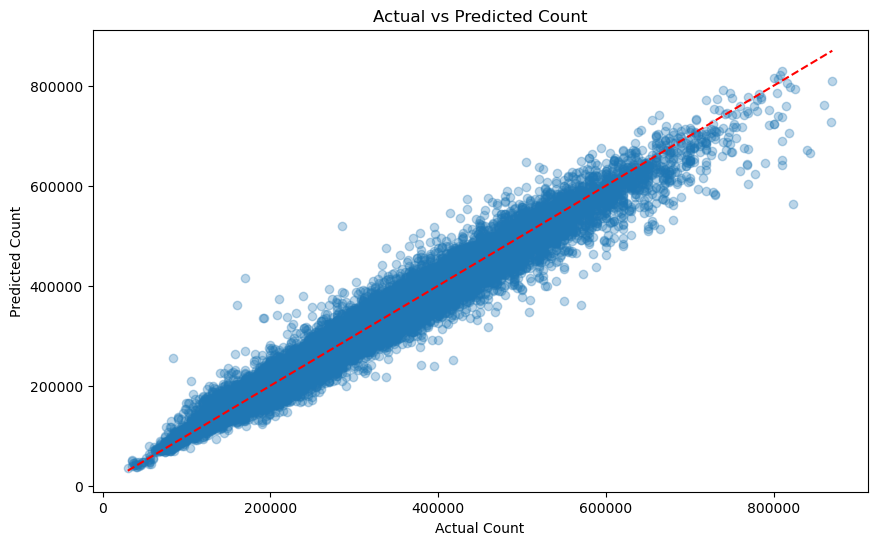

In [19]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Actual vs Predicted Count')
plt.show()